# Introduction

This Jupyter notebook validates the Python code used in Supporting Materials 1.

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from mpmath import mp
%run -i ./Code/utilities.py
%run -i ./Code/graphics.py
"""
Figures are non-interactive. They are saved in subdirectory ./Figures/
of the directory containing this notebook.
"""
plt.interactive(False)
DIR = './Figures/'
ensure_directory_exists(DIR)
"""
Set the number of digits of precision for multiprecision floating-point
operations in the global environment.
"""
mp.dps = 200
"""
Indicate when this code cell was last executed.
"""
from datetime import datetime
print("Time stamp:", datetime.now())

Time stamp: 2020-05-05 04:04:23.250337


# High-level validation

We show that our implementation of the Euler method in class `Solver` produces results similar to, though less accurate than, those of an implementation of the Runge-Kutta 4(5) method in the Scientific Python (SciPy) package. We also show that our method of finding an eigenvector corresponding to the dominant eigenvalue of the deriviative operator $W$ yields results more accurate than those of a SciPy method.

## Check implementation of the Euler method

With the threshold relative frequency of zero, an instance of class `Solver` implements the Euler method, and solves for frequencies in the infinite-population model. As in Supporting Materials 1, we set the step size $h=2^{-7}\!.$ For the Euler method, also known as the Runge-Kutta 2(1) method, the error in each individual step is $O(h^2),$ and accumulated error is $O(h)$ at all times. For the Runge-Kutta 4(5) method, the error in each individual step is $O(h^5),$ and the accumulated error is $O(h^4)$ at all times. Irrespective of which method is applied, the calculated relative frequencies approach an equilibrium, and the accumulated error eventually becomes very small. The main question addressed here is whether the Euler solutions are reasonably close to the Runge-Kutta 4(5) solutions *prior to convergence to the equilibrium distribution.*

**Solution by Euler and Runge-Kutta 4(5) methods**

In [3]:
%%time
"""
We use a library routine for solving the initial value problem.
"""
from scipy.integrate import solve_ivp

%run -i ./Code/parameters.py
%run -i ./Code/solver.py

def euler_solutions(params, n_years, log_steps_per_year=7):
    """
    Returns `Solver` instance run for `n_years` with threshold zero.
    """    
    W = params.W.astype(float)
    initial_freqs = params.initial_freqs().astype(float)
    threshold = 0.0
    solver = Solver(W, initial_freqs, log_steps_per_year, threshold)
    solver(n_years)
    return solver

def rk45_solutions(params, n_years, step_size):
    """
    Returns solutions obtained using the Runge-Kutta 4(5) method.
    
    Normalized solutions at times 0, 1, ..., `max_year` are returned,
    with the solutions for year 0 equal to `params.initial_freqs()`. 
    
    The derivative operator is `params.W`. The solver takes time steps
    of size `step_size`.
    """
    # Define a function for calculation of the derivative. It will
    # be called with the time as the first parameter, even though the
    # derivative does not depend on the time.
    W = params.W.astype(float)
    derivative = lambda t, s: W @ s
    #
    # Scale the initial frequencies by an integer power of 2 to avoid
    # over(under)flow in derivative calculations.
    init = params.initial_freqs().astype(float)
    bias_exponents(init, 512)
    #
    # The initial-value-problem solver must be given the times at
    # which to produce solutions.
    times = linspace(0.0, n_years, n_years + 1)
    interval = (times[0], times[-1] + step_size)
    result = solve_ivp(derivative, interval, init, method='RK45',
                       t_eval=times, max_step=step_size, rtol=1e-13,
                       atol=1e-11)
    print(result.message)
    #
    # Transpose the array of solutions to make rows correspond to
    # times. Then normalize the solutions at each time, using `fsum()`
    # to calculate sums accurately.
    solutions = result.y.T
    for i in range(len(solutions)):
        solutions[i] /= fsum(solutions[i])
    return solutions

params = Parameters(b_max=0.2, gamma='1e-3')
euler = euler_solutions(params, 1600, log_steps_per_year=7)
rk45 = rk45_solutions(params, len(euler)-1, euler.step_size)

The solver successfully reached the end of the integration interval.
CPU times: user 6min 29s, sys: 14.2 s, total: 6min 44s
Wall time: 1min 52s


**Numerical comparison of Euler and Runge-Kutta 4(5) solutions**

We verify not only that the discrepancy of solutions obtained by the Euler and Runge-Kutta 4(5) methods is small, but also that the discrepancy is reduced when the step size is reduced in the Euler method.

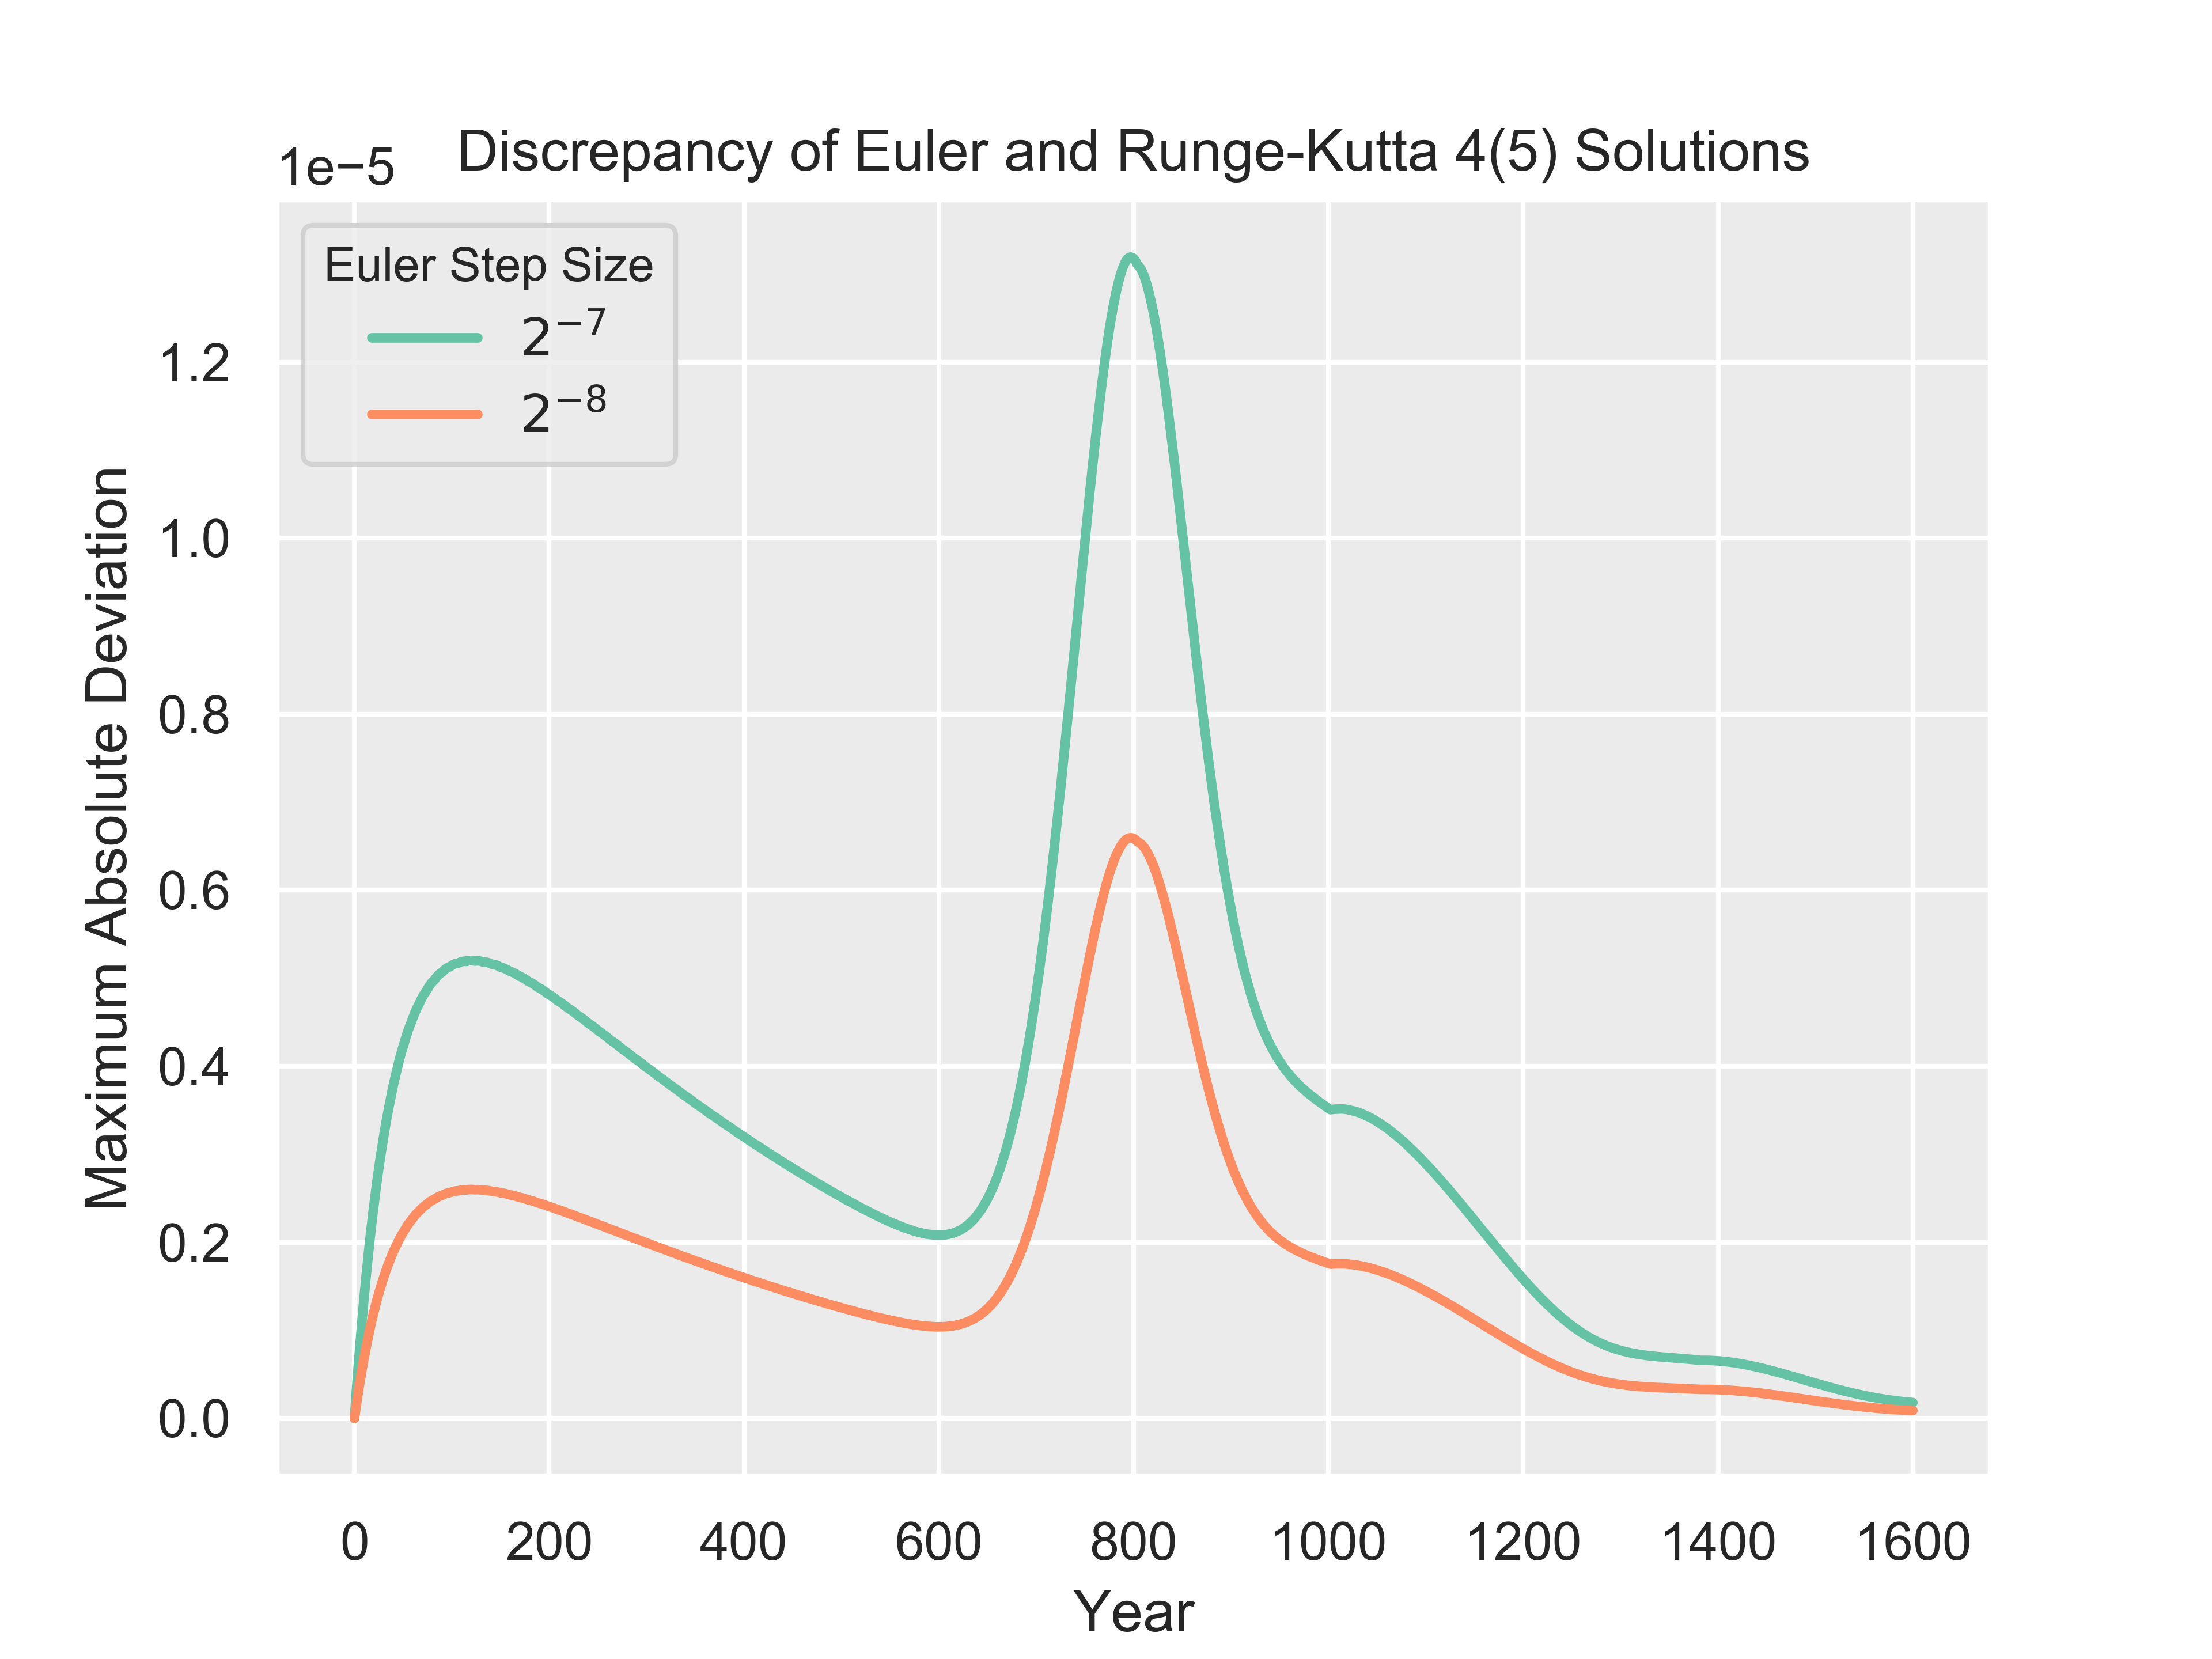

In [4]:
def plot_mad(eulers, rk45s):
    fig, ax = plt.subplots()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xlabel('Year')
    ax.set_ylabel('Maximum Absolute Deviation')
    t = 'Discrepancy of Euler and Runge-Kutta 4(5) Solutions'
    ax.set_title(t)
    for euler, rk45 in zip(eulers, rk45s):
        errs = [np.max(np.abs(s - rk))
                    for s, rk in zip(euler, rk45)]
        ax.plot(errs, label=exp_latex(euler.step_size))
    ax.legend(title='Euler Step Size', loc='upper left', 
              title_fontsize='small')
    save_and_display(fig, DIR + 'tmp.png')

better_euler = euler_solutions(params, len(euler)-1, log_steps_per_year=8)
plot_mad([euler, better_euler], [rk45, rk45])

In the plot above, the maximum absolute deviation of solutions $\mathbf{s}_k$ and $\mathbf{s}^\prime_k$ is $\lVert \mathbf{s}_k - \mathbf{s}^\prime_k \rVert_\infty.$

**Visual comparison of Euler and Runge-Kutta 4(5) solutions**

In the following plot of solutions in select years, we include years in which the discrepancy of Euler and Runge-Kutta 4(5) solutions peaks.

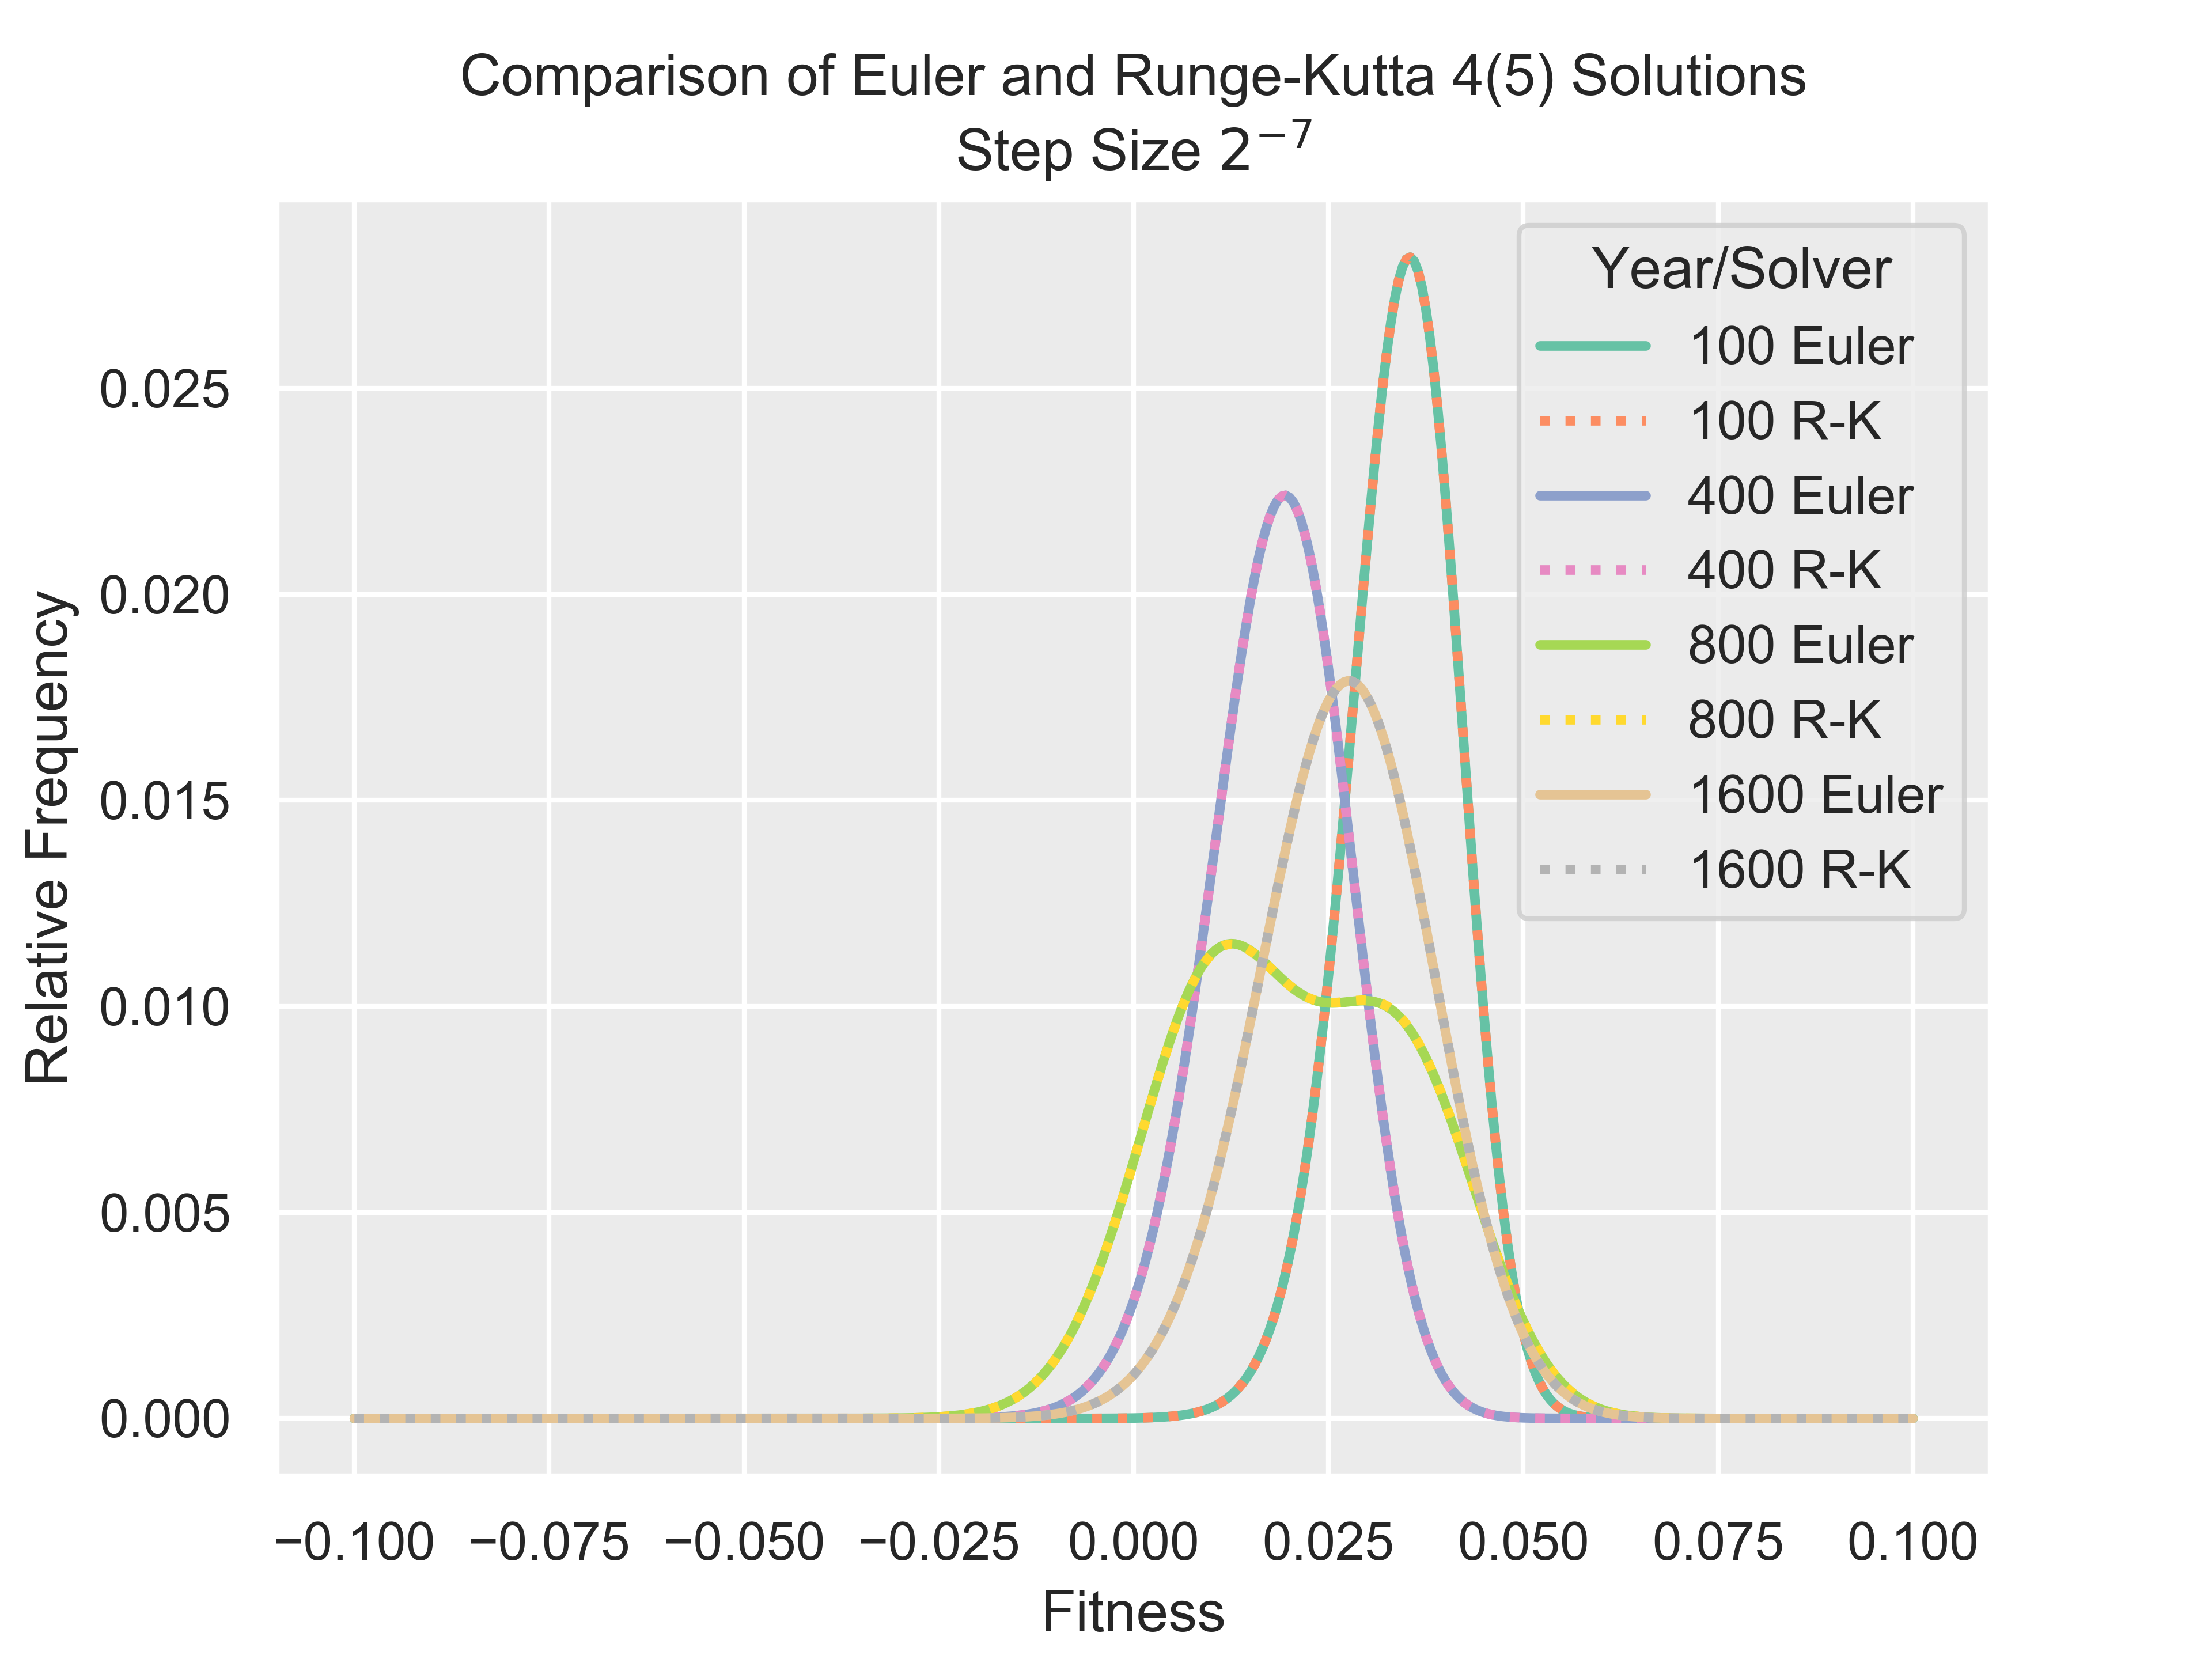

In [5]:
def plot_euler_rk(euler, rk, years):
    """
    Plot `euler` and `rk` solutions for given `years`.
    """
    n_colors = 2 * len(years)
    sns.set_palette(sns.color_palette("Set2", n_colors))
    fig, ax = plt.subplots()
    t = 'Comparison of Euler and Runge-Kutta 4(5) Solutions\n'
    t = t + 'Step Size {}'.format(exp_latex(euler.step_size))
    ax.set_title(t)
    ax.set_xlabel('Fitness')
    ax.set_ylabel('Relative Frequency')
    #
    for i in years:
        ax.plot(params.m, euler[i], label='{:d} Euler'.format(i)) 
        ax.plot(params.m, rk[i], label='{:d} R-K'.format(i), ls=':')
    ax.legend(title='Year/Solver', loc='best')
    save_and_display(fig, DIR + 'tmp.png')

plot_euler_rk(euler, rk45, [100, 400, 800, len(euler)-1])

## Check of equilibrium distribution

The `equilibrium` function (listed in the following code cell) obtains a first approximation of the equilibrium distribution by passing the derivative operator $W$ to the `eig` function of SciPy's linear algebra package, and selecting the eigenvector corresponding to the largest real eigenvalue. The elements of the eigenvector are replaced by their absolute values. If the `maxiter` parameter of `equilibrium` is set to zero, then the function returns the first approximation.

In [7]:
# %load ./Code/eigen.py
from scipy import linalg


def equilibrium(W, max_error=1e-14, maxiter=10**5):
    """
    Finds the equilibrium distribution for derivative operator `W`.
    
    Returns 
        * the largest real eigenvalue of square array `W`,
        * an eigenvector `v` corresponding to the eigenvalue, and
        * the error `eig_error(W, v)` of the calculated eigenpair.
    
    The equilibrium is initially approximated using a function in the
    SciPy package. Then the approximation is iteratively improved. The
    calculation proceeds until the error is no greater than `max_error`,
    or the number of iterations exceeds `max_iterations`.
    """
    # Get a first approximation of an eigenvector corresponding to the
    # largest real eigenvalue of `W`, using the `eig` function of 
    # SciPy's linear algebra package. The elements of the eigenvector
    # complex numbers, possibly with negative real components. Thus we
    # replace the elements with their absolute values.
    e_values, e_vectors = linalg.eig(W)
    which = np.argmax(e_values.real)
    e_vector = np.abs(e_vectors[:,which])
    #
    # Create an instance of `Solver` with threshold relative frequency
    # of zero, step size of one year, and initial frequencies equal to
    # the first approximation of the eigenvector.
    solver = Solver(W, e_vector, 1, threshold=0)
    #
    # Run the solver repeatedly, 1000 iterations per run, until the
    # solution converges to an eigenvector of `W` or the maximum 
    # number of iterations is exceeded.
    error, e_value = eigen_error(W, solver.s)
    while error > max_error and len(solver) <= maxiter:
        solver(1000)
        error, e_value = eigen_error(W, solver.s)
    return e_value, solver.s, error


def eigen_error(W, v):
    """
    Evaluates an approximate eigenvector `v` of square matrix `W`.
    
    The corresponding approximate eigenvalue `e_value` is calculated.
    The error of the approximate eigenvector `v` of `W` is returned,
    along with the corresponding approximate eigenvalue `e_value`. The
    error is the maximum absolute error of `e_value * v` relative to
    the matrix product of `W` and `v`.
    
    Assumption: The elements of the matrix product of `W` and `v` are
    all positive.
    """
    # Set `e_value` to the Rayleigh quotient R(W, v).
    product = W @ v
    e_value = np.dot(v, product) / np.dot(v, v)
    #
    # Calculate the maximum absolute relative error, assuming that
    # elements of `product` are strictly positive. NumPy will issue a
    # warning if any of the elements are zero.
    relative_errors = (e_value * v - product) / product
    mare = np.max(np.abs(relative_errors))
    return mare, e_value

We verify that the absolute difference in the first approximation and the final approximation of the eigenpair is small. We verify also that the relative error in approximation, as measured by `eigen_error`, is much smaller in the final approximation than in the first approximation.

Approximation errors according to eigen_error()
    First: 1.988442335823651
    Final: 4.259575566498284e-15
Absolute difference of eigenvalues    : 2.5673907444456745e-16
Max absolute deviation of eigenvectors: 2.671474153004283e-16


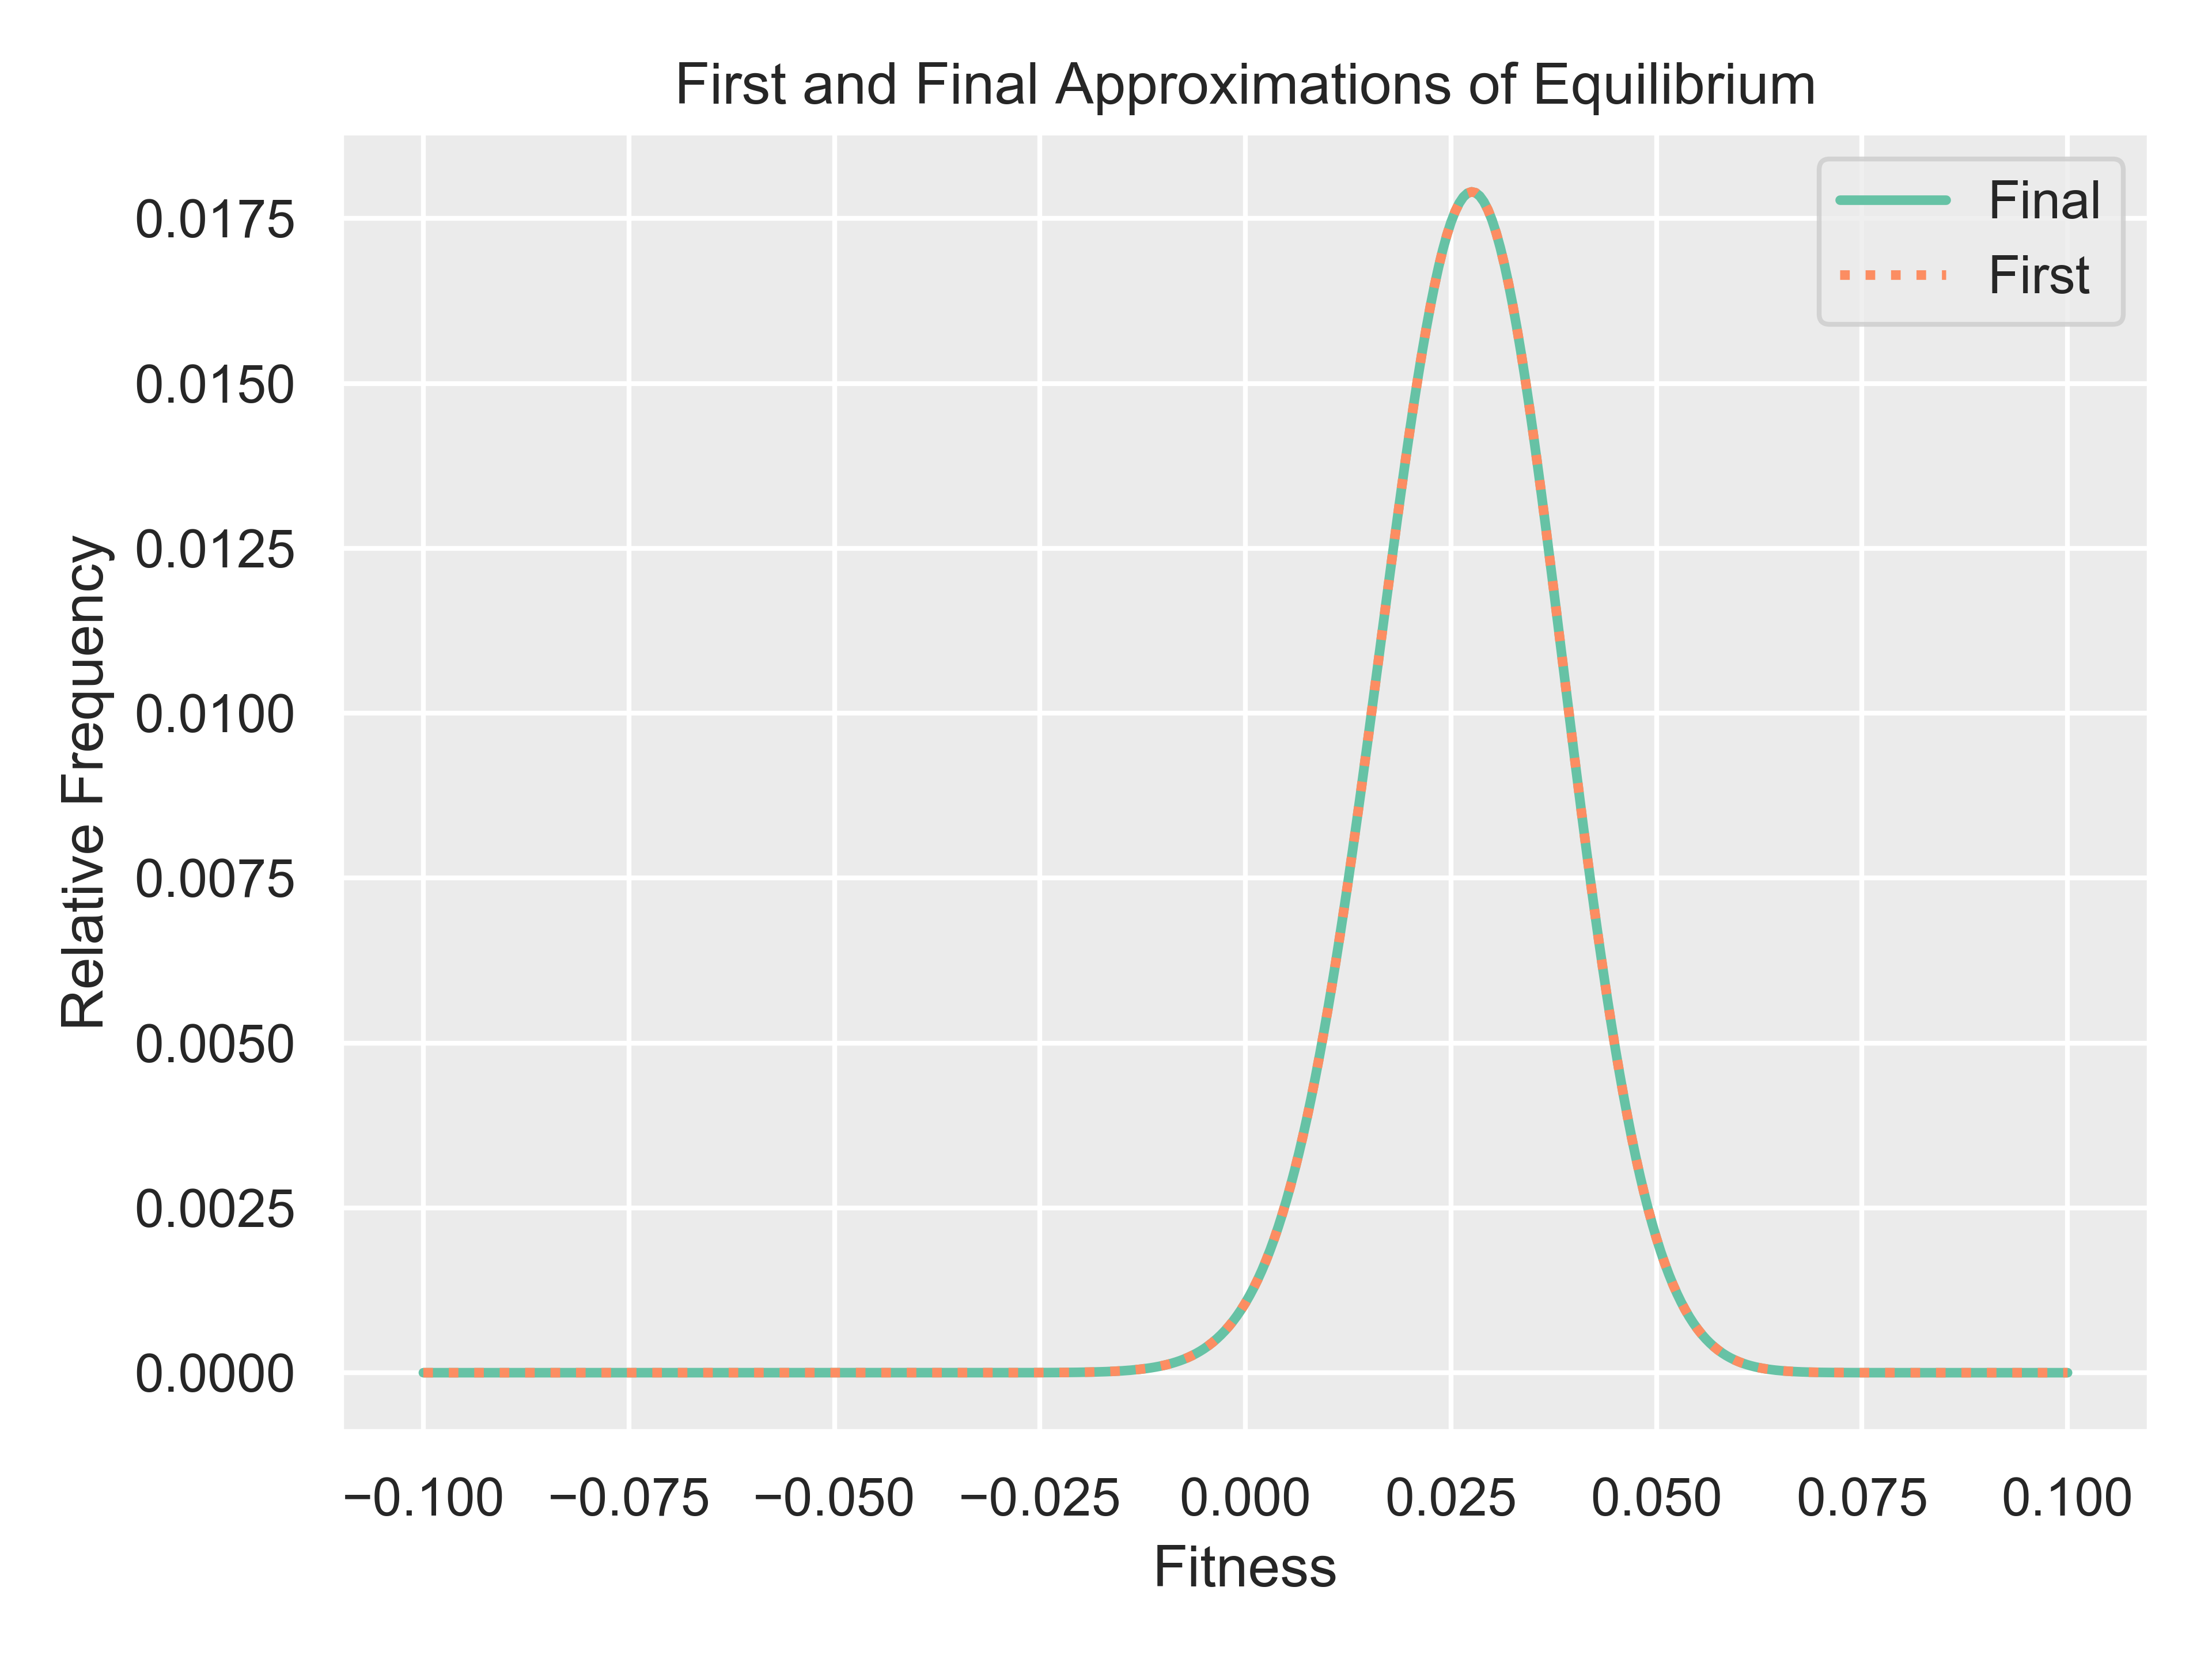

In [28]:
def check_equilibrium(W, m):
    e_value0, e_vector0, error0 = equilibrium(W, maxiter=0)
    e_vector0 /= np.sum(e_vector0)
    e_value, e_vector, error = equilibrium(W)
    e_vector /= np.sum(e_vector)
    value_diff = abs(e_value - e_value0)
    vector_mad = np.max(e_vector0 - e_vector)
    print('Approximation errors according to eigen_error()')
    print('    First:', error0)
    print('    Final:', error)
    print('Absolute difference of eigenvalues    :', value_diff)
    print('Max absolute deviation of eigenvectors:', vector_mad)
    fig, ax = plt.subplots()
    title = 'First and Final Approximations of Equilibrium'
    ax.set_title(title)
    ax.plot(m, e_vector, label='Final')
    ax.plot(m, e_vector0, label='First', ls=':')
    ax.set_xlabel('Fitness')
    ax.set_ylabel('Relative Frequency')
    ax.legend(loc='best')
    fig.tight_layout()
    save_and_display(fig, DIR + 'tmp.png')

check_equilibrium(euler.W, params.m)

Now we test the `equilibrium` function on a simple example [worked out in  Wikipedia](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors#Eigenvectors). The largest real eigenvalue is 6, and an eigenvector associated with 6 is $[1, 2]^t.$

In [21]:
def check_eig_example(W):
    e_value, e_vector, error = equilibrium(W)
    e_vector /= e_vector[0]
    print('Eigenvalue :', e_value)
    print('Eigenvector:', e_vector)
    print('Error      :', error)
    
W = np.array([[4, 1],
              [6, 3]])
check_eig_example(W)

Eigenvalue : 6.000000000000001
Eigenvector: [1. 2.]
Error      : 1.6550227688315153e-16


Another example is worked out [here](http://wwwf.imperial.ac.uk/metric/metric_public/matrices/eigenvalues_and_eigenvectors/eigenvalues2.html). The largest real eigenvalue is 6, and an eigenvector associated with 6 is $[1, 6, 16]^t.$

In [25]:
W = np.array([[-2, -4,  2],
              [-2,  1,  2],
              [ 4,  2,  5]])
check_eig_example(W)

Eigenvalue : 6.000000000000002
Eigenvector: [ 1.  6. 16.]
Error      : 2.3754946299780506e-15


# Thresholding stuff

In [ ]:
threshold = 3.0

In [ ]:
a = np.arange(401.0)
a = np.minimum(a, a[::-1])

trim(a, threshold), a[:10], a[-10:]

In [ ]:
a = np.arange(401.0)
a = np.minimum(a, a[::-1])

alt_trim(a, threshold), a[:10], a[-10:]

In [ ]:
%timeit trim(a, threshold)

In [ ]:
%timeit alt_trim(a, threshold)

In [ ]:
a,p = math.frexp(mp.mpf('123.45'))
type(a), type(p)

In [ ]:
b=convert(a, mp.mpf)
b

In [ ]:
relative_error(b*0.5,a)

In [ ]:
b[0,0] = 1
b

In [ ]:
c=relative_error(b.astype(float)*0.5,a)
#np.abs(c, out=c)
np.max(abs(c))

In [ ]:
abs(-np.inf)

In [ ]:
mp_float(a)